In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from scipy.optimize import fmin_slsqp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
import os
import sys
from pathlib import Path
ROOT_PATH = Path().absolute().parent.parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs

## Band Reqularization
When these outputs were generated the FrequencyResponse parametric eq optimizer had regularization for filter bands extending Nyquist frequency.

The implementation was based on calculating equalizer frequency response at both 44.1 kHz and 192 kHz and the loss was a sum of mean squared errors.
Essentially the filters would be optimized for all sampling rates as well as for parametric equalizer implementations which don't squeeze the filter bands near Nyquist frequency.

The results indicate that regularization only hurts

In [3]:
def compare_regularization(fp, n, plot=True):
    fr = FrequencyResponse.read_from_csv(fp)
    ix = np.sum(fr.frequency < 10e3)
    if plot:
        fig, axs = plt.subplots(1, 2)
        fig.set_size_inches(30, 12)
    times = []
    rmses = []
    ref_rmses = []
    
    for i, regularize in zip(range(0, 2), [False, True]):
        t = time()
        filters, n_filters, max_gains = fr.optimize_parametric_eq(n, fs=44100, regularize_band=regularize, regularize_q=False)
        times.append(time() - t)
        rmse = np.sqrt(np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr.parametric_eq[:ix]))))
        rmses.append(rmse)
        
        fc, q, gain = np.split(filters, 3, axis=1)
        fr_ref = digital_coeffs(fr.frequency, 192e3, *peaking(fc, q, gain, fs=192e3), reduce=True)
        ref_rmse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr_ref[:ix])))
        ref_rmses.append(ref_rmse)
        
        if plot:
            #plot_filters(fr, filters, fig, axs[i])
            fr.plot_graph(fig=fig, ax=axs[i], raw=False, smoothed=False, error=False, error_smoothed=False, target=False, equalization=True, equalized=False, parametric_eq=True, fixed_band_eq=False, show=False)
            
            axs[i].plot(fr.frequency, fr_ref - 0.1, ':', label='192 kHz')
            axs[i].legend()
            axs[i].set_title(f'Regularize = {regularize}, RMSE = {rmse:.2f} dB, Ref RMSE = {ref_rmse:.2f} dB')
        
    if plot:
        y_lim = axs[0].get_ylim() + axs[1].get_ylim()
        axs[0].set_ylim([np.min(y_lim), np.max(y_lim)])
        axs[1].set_ylim([np.min(y_lim), np.max(y_lim)])
        plt.show()
    return times, rmses, ref_rmses

In [ ]:
n = [5, 5]
data = []
for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
    times, rmses, ref_rmses = compare_regularization(fp, n, plot=False)
    data.append([
        times[0],
        times[1],
        times[1] - times[0],
        times[1] / times[0],
        rmses[0],
        rmses[1],
        rmses[1] - rmses[0],
        rmses[1] / rmses[0],
        ref_rmses[0],
        ref_rmses[1],
        ref_rmses[1] - ref_rmses[0],
        ref_rmses[1] / ref_rmses[0],
    ])

In [9]:
df = pd.DataFrame(data, columns=['t (unreg)', 't (reg)', 't (diff)', 't (ratio)', 'RMSE-44 (unreg)', 'RMSE-44 (reg)', 'RMSE-44 (diff)', 'RMSE-44 (ratio)', 'RMSE-192 (unreg)', 'RMSE-192 (reg)', 'RMSE-192 (diff)', 'RMSE-192 (ratio)'])
df

,t (unreg),t (reg),t (diff),t (ratio),RMSE-44 (unreg),RMSE-44 (reg),RMSE-44 (diff),RMSE-44 (ratio),RMSE-192 (unreg),RMSE-192 (reg),RMSE-192 (diff),RMSE-192 (ratio)
0,0.507114,0.820184,0.313070,1.617355,0.668826,0.868760,0.199934,1.298932,0.540440,0.558311,0.017871,1.033068
1,0.459104,0.462104,0.003000,1.006536,0.526285,0.607402,0.081117,1.154132,0.448617,0.404871,-0.043746,0.902487
2,0.497112,0.976220,0.479108,1.963784,0.600015,0.796246,0.196230,1.327042,0.389960,0.557778,0.167818,1.430348
3,0.524626,0.749168,0.224542,1.428003,0.505538,0.873341,0.367803,1.727548,0.592485,0.755851,0.163366,1.275730
4,0.635142,0.844799,0.209657,1.330095,0.484568,0.873516,0.388948,1.802669,0.511796,0.791902,0.280106,1.547300
...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.386086,0.711160,0.325073,1.841970,0.645826,0.833413,0.187587,1.290460,0.863025,0.692786,-0.170238,0.802742
476,0.497112,0.720162,0.223050,1.448692,0.753406,0.817437,0.064030,1.084988,0.543803,0.616448,0.072645,1.133588
477,0.333075,0.681153,0.348078,2.045045,0.715766,0.833041,0.117275,1.163845,0.529410,0.684255,0.154845,1.292485
478,0.420094,0.664149,0.244055,1.580952,0.633148,0.678166,0.045018,1.071102,0.404798,0.427061,0.022263,1.054998


In [10]:
df.describe()

,t (unreg),t (reg),t (diff),t (ratio),RMSE-44 (unreg),RMSE-44 (reg),RMSE-44 (diff),RMSE-44 (ratio),RMSE-192 (unreg),RMSE-192 (reg),RMSE-192 (diff),RMSE-192 (ratio)
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.510569,0.795521,0.284952,1.607376,0.615083,0.744754,0.129671,1.241018,0.653411,0.565940,-0.087471,1.058279
std,0.090445,0.154439,0.161727,0.445490,0.138024,0.139246,0.127647,0.241315,0.453738,0.215192,0.425317,0.471906
min,0.180040,0.382087,-0.190962,0.688315,0.269487,0.390710,-0.275262,0.692994,0.117116,0.175220,-2.903902,0.151862
25%,0.459106,0.700908,0.178040,1.324246,0.511170,0.646426,0.035194,1.054876,0.372976,0.406311,-0.146929,0.781203
50%,0.514115,0.788475,0.293674,1.565353,0.600278,0.741052,0.117243,1.190679,0.529636,0.534613,0.011256,1.032376
75%,0.575379,0.888223,0.379298,1.817652,0.701122,0.836317,0.216595,1.392445,0.744526,0.691215,0.126345,1.294425
max,0.744167,1.248792,0.883198,5.528206,1.135645,1.150197,0.559838,2.008319,3.576975,1.350377,0.891266,4.028391


## Conclusions
As can be seen from the statistical metrics, the regularization always increases RMSE for both sampling rates while increasing the optimization time by 41% on average.

Therefore regularization should not be used

## Parametric Equalizer Band Reqularization
Penalizing for filters whos transition bands extend Nyquist frequency

**NOTE** This is an older approach which was replaced by calculating frequency responses for 44.1 kHz and 192 kHz

In [73]:
def q2bw(q):
    return np.log2(np.log(1 + 1 / (2 * q**2) + np.sqrt(((2 * q**2 + 1) / q**2 )**2 / 4 - 1)))

AOC ratio until Nyquist = 0.87
1.81


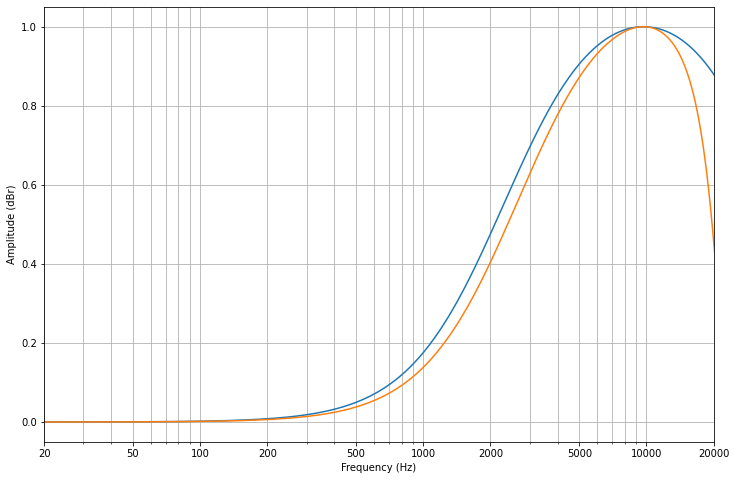

In [74]:
fs = 44100
f = FrequencyResponse.generate_frequencies(f_max=192e3)
fc = 9699
q = 0.224
bw = q2bw(q)
fr_ref = digital_coeffs(f, 192e3, *peaking(fc, q, 1, fs=192e3))
fr_corrupted = digital_coeffs(f, 44100, *peaking(fc, q, 1, fs=fs))
f_step = np.log2(f[1] / f[0])
ix = np.argmin(np.abs(fs / 2 - f))
print(f'AOC ratio until Nyquist = {np.sum(fr_corrupted[:ix]) / np.sum(fr_ref[:ix]):.2f}')

f_insp = fc / (2**(bw / 2))
ix_insp = np.argmin(np.abs(f_insp - f))
print(f'{fr_corrupted[ix_insp] / 0.5:.2f}')

fig, ax = FrequencyResponse.init_plot()
ax.plot(f, fr_ref, label='Reference')
ax.plot(f, fr_corrupted, label='True')
#ax.set_xlim([20, fs / 2])
plt.show()

In [557]:
ix_max = np.argmin(np.abs(fr_corrupted - np.max(fr_corrupted)))
ix = np.argmin(np.abs(fr_corrupted[:ix_max] - np.max(fr_corrupted) / 2))
print(f[ix], fr_corrupted[ix], '/', fr_ref[ix], '=', fr_corrupted[ix] / fr_ref[ix])

5752.964286311504 0.4961516832741162 / 0.5908064997220066 = 0.8397871105134616


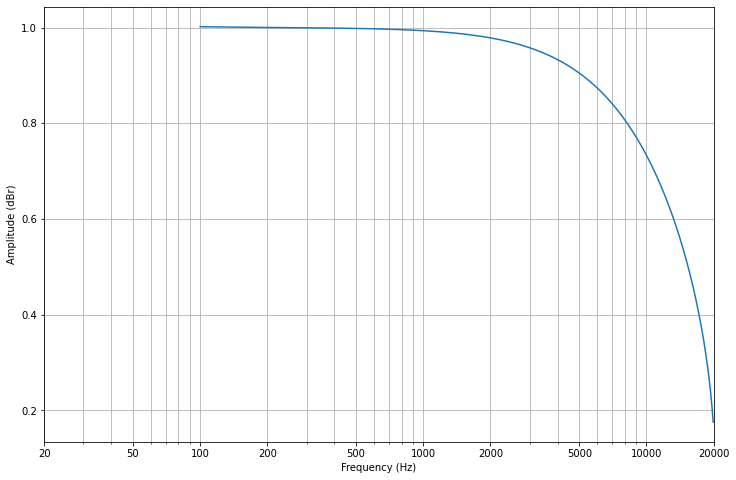

In [6]:
fs = 44.1e3
f = FrequencyResponse.generate_frequencies(f_max=192e3)
f_step = np.log2(f[1] / f[0])
ix_fs = np.argmin(np.abs(fs / 2 - f))

f_points = np.arange(1e2, 20e3, 100)
ratios = []
for fc in f_points:
    fr_ref = digital_coeffs(f, 192e3, *peaking(fc, np.sqrt(2), 1, fs=192e3))
    fr_corrupted = digital_coeffs(f, 44100, *peaking(fc, np.sqrt(2), 1, fs=fs))
    ratios.append(np.sum(fr_corrupted[:ix_fs]) / np.sum(fr_ref[:ix_fs]))
    
fig, ax = FrequencyResponse.init_plot()
ax.plot(f_points, ratios)
plt.show()